# Processing 2020 VMT
## For COVID project
## Bumsik Kim

# <font color='yellow'>1. Import libraries</font>

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import matplotlib as mpl
import time

In [2]:
DataPath = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Task5_GISWork\\Clipped_Table"

YearList = [*range(2012, 2021)]
AreaList = ['HGAC', 'NCTCOG']
FileList = list()

for i in YearList:
    for j in AreaList:
        FileName = j + '_' + str(i) + '_Int.csv'
        FileList.append(FileName)

print (FileList)

['HGAC_2012_Int.csv', 'NCTCOG_2012_Int.csv', 'HGAC_2013_Int.csv', 'NCTCOG_2013_Int.csv', 'HGAC_2014_Int.csv', 'NCTCOG_2014_Int.csv', 'HGAC_2015_Int.csv', 'NCTCOG_2015_Int.csv', 'HGAC_2016_Int.csv', 'NCTCOG_2016_Int.csv', 'HGAC_2017_Int.csv', 'NCTCOG_2017_Int.csv', 'HGAC_2018_Int.csv', 'NCTCOG_2018_Int.csv', 'HGAC_2019_Int.csv', 'NCTCOG_2019_Int.csv', 'HGAC_2020_Int.csv', 'NCTCOG_2020_Int.csv']


# <font color='yellow'> 2. Summarize all VMT data </font>

1. Define Functions
2. Recalculate VMT: Since segment length is recalculated, VMT should be recalculated as well
3. Groupby County Name: sum VMT (from 1) by each county
4. Merge all year's result into one

In [16]:

## Define Functions


def RecalculateVMT (df):
    df['VMT'] = df['Length_mi'] * df['ADT_CUR']
    return df

def Groupby_County (df, Year, Area):
    df_group = df.loc[:, ['FIPS', 'VMT']]
    df_group.loc[:, 'Year'] = Year
    df_group.loc[:, 'Area'] = Area
    df_group.set_index(['Year', 'Area', 'FIPS'])
    ##df_group = df_group.groupby(['Year', 'Area', 'FIPS']).VMT.sum()
    df_group = df_group.groupby(['Year', 'Area', 'FIPS']).sum()
    return df_group

def Merge_df(df1, df2):
    ##df = pd.merge(df1, df2, how = 'outer', on=['Year', 'Area', 'FIPS']) 
    df = pd.merge(df1, df2, on=['Year', 'Area', 'FIPS']) 
    return df

def Concat_df(df1, df2):
    ##df = pd.merge(df1, df2, how = 'outer', on=['Year', 'Area', 'FIPS']) 
    Frames = [df1, df2]
    df = pd.concat(Frames) 
    return df



#### 2.1 GRID network system

In 2017, GRID has CG, LG, and RG for interstate highways (RDBD_ID). CG means center line, LG and RG represents left and right link (by each direction)

Since 2018, GRID has KG, LG, and RG for interstate highways (RDBD_ID). KG means center line, LG and RG represents left and right link (by each direction)

But all the three lane have VMT in the link properties, so one should be removed.

Keep KG for VMT calculation

Remove all LG and RG in RDBD_ID between 2017-2021. 

I also checked one-way road (median type = 0), but even on the one-way road, there is KG line exist between LG and RG. (usually one-way lane has two pairs)


In [53]:
## Main Function

## GRID data is clipped by each county boundary and saved as csv format
DataPath = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Task5_GISWork\\Clipped_Table"
OutputPath = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Task5_GISWork\\Clipped_Table_RemoveLGRG"

YearList = [*range(2012, 2022)]
AreaList = ['HGAC', 'NCTCOG']
FileList = list()

df_summary = pd.DataFrame()

for i in YearList:
    for j in AreaList:
        FileName = j + '_' + str(i) + '_Int.csv'
        FileList.append(FileName)

        FilePath = os.path.join(DataPath, FileName)
        df = pd.read_csv(FilePath)
        df = df.loc[df['FIPS'].isin([48257, 48139, 48221, 48251, 48231, 48497, 48121, 48085, 48397, 48367, 48113, 48439, 48291, 48473, 48201, 48339, 48071, 48157, 48167, 48039])] ## Some links were included even though I clipped it by MPO boundary, so leave links in NCTCOG and HGAC only and remove others
        df = df.rename(columns={'OID_': 'ID_GIS'}) ## Rename ID in GIS
        df['Area'] = str(j) ## Add area name in the dataset

        if i >= 2017:
            df = df[~df['RDBD_ID'].isin(['LG', 'RG'])] ## ~ operator means invert, so it is 'not in' operator. Exclude all LG and RG link in the dataset

        df = RecalculateVMT(df) ## Recalculate VMT since link lengths are changed due to clipping
        
        OutputFilePath = os.path.join(OutputPath, FileName)
        df.to_csv(OutputFilePath) ## Save filtered data to new output folder

        df = Groupby_County(df, i, j) ## Aggregate (sum) VMT by county

        if len(df_summary.index) == 0: ## Save the result as df_summary
            df_summary = df
        else:
            ##df_summary = Merge_df(df_summary, df)
            df_summary = Concat_df(df_summary, df)
        

        
print (df_summary) ## Return summary table (Index: Int(year), Str(Area), Int(FIPS) )

C:\Users\B-Kim\AppData\Local\Temp\ipykernel_30376\389400277.py:19: DtypeWarning: Columns (12,15,16,19,20,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FilePath)
C:\Users\B-Kim\AppData\Local\Temp\ipykernel_30376\389400277.py:19: DtypeWarning: Columns (15,16,19,20,69,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FilePath)
C:\Users\B-Kim\AppData\Local\Temp\ipykernel_30376\389400277.py:19: DtypeWarning: Columns (12,15,16,19,20,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FilePath)
C:\Users\B-Kim\AppData\Local\Temp\ipykernel_30376\389400277.py:19: DtypeWarning: Columns (15,16,19,20,40,155) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FilePath)
C:\Users\B-Kim\AppData\Local\Temp\ipykernel_30376\389400277.py:19: DtypeWarning: Columns (12,15,16,19,20,40,156,157) have mixed types. Specify dtype 

                            VMT
Year Area   FIPS               
2012 HGAC   48039  5.477709e+06
            48071  2.382426e+06
            48157  8.624785e+06
            48167  5.300845e+06
            48201  9.249701e+07
...                         ...
2021 NCTCOG 48257  5.284008e+06
            48367  5.031499e+06
            48397  3.064853e+06
            48439  6.288357e+07
            48497  2.845484e+06

[200 rows x 1 columns]


# <font color='yellow'> 3. Calculate VMT in 2020 </font>

1. Calculate number of days in each period (and %)
2. Load VMT ratio from observation (2020 Before lockdown = 1)
3. Calcualte predicted VMT by each period in 2020

In [54]:
## Number of Days


P1_Start = date(2019, 12, 31)
P1_End = date(2020, 3, 20)
P2_End = date(2020, 4, 30)
P3_End = date(2020, 9, 30)
P4_End = date(2020, 12, 31)

## Count number of days in each period
P1_Days = P1_End - P1_Start
P2_Days = P2_End - P1_End
P3_Days = P3_End - P2_End
P4_Days = P4_End - P3_End

P1_Days = P1_Days.days
P2_Days = P2_Days.days
P3_Days = P3_Days.days
P4_Days = P4_Days.days

## Count number of weekdays in each period
P1_WKDays = np.busday_count(P1_Start, P1_End)
P2_WKDays = np.busday_count(P1_End, P2_End)
P3_WKDays = np.busday_count(P2_End, P3_End)
P4_WKDays = np.busday_count(P3_End, P4_End)
## Count number of weekends in each period
P1_WEDays = P1_Days - P1_WKDays
P2_WEDays = P2_Days - P2_WKDays
P3_WEDays = P3_Days - P3_WKDays
P4_WEDays = P4_Days - P4_WKDays

print("Before Lockdown: %i days, %i Weekdays, %i weekends" % (P1_Days, P1_WKDays, P1_WEDays))
print("Lockdown Phase I: %i days, %i Weekdays, %i weekends" % (P2_Days, P2_WKDays, P2_WEDays))
print("Lockdown Phase II: %i days, %i Weekdays, %i weekends" % (P3_Days, P3_WKDays, P3_WEDays))
print("After Lockdown: %i days, %i Weekdays, %i weekends" % (P4_Days, P4_WKDays, P4_WEDays))

## Calculate fraction of weekdays and weekends
TotalDays = P1_Days + P2_Days + P3_Days + P4_Days
P1_Pct = P1_Days/TotalDays
P2_Pct = P2_Days/TotalDays
P3_Pct = P3_Days/TotalDays
P4_Pct = P4_Days/TotalDays

P1_WD_Pct = P1_WKDays/TotalDays
P2_WD_Pct = P2_WKDays/TotalDays
P3_WD_Pct = P3_WKDays/TotalDays
P4_WD_Pct = P4_WKDays/TotalDays
P1_WE_Pct = P1_WEDays/TotalDays
P2_WE_Pct = P2_WEDays/TotalDays
P3_WE_Pct = P3_WEDays/TotalDays
P4_WE_Pct = P4_WEDays/TotalDays

## Generate dataframe
DaysPercent = {'DaysPercent': [P1_Pct, P2_Pct, P3_Pct, P4_Pct]}
df_DaysPercent = pd.DataFrame(data=DaysPercent, index = ['1- Before Lockdown', '2- Lockdown- Phase I', '3- Lockdown- Phase II', '4- After Lockdown'])

Days_WDWE_Percent = {'DaysPercent': [P1_WD_Pct, P1_WE_Pct, P2_WD_Pct, P2_WE_Pct, P3_WD_Pct, P3_WE_Pct, P4_WD_Pct, P4_WE_Pct]}
list_index_iterable = [['1- Before Lockdown', '2- Lockdown- Phase I','3- Lockdown- Phase II','4- After Lockdown'], ['Weekday', 'Weekend']]
df_index = pd.MultiIndex.from_product(list_index_iterable)
df_Days_WDWE_Percent = pd.DataFrame(data = Days_WDWE_Percent, index = df_index)


## Load VMT ratio from csv
## VMT ratio by each period is calculated from existing PowerBI by Mohammad
## VMT ratio: Before lockdown = 1, VMT ratio for each period
VMT_Ratio_byCounty_Path = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\STARS_Data_Analysis\\Ratios_byCounty_02282023.csv" ## by county
VMT_Ratio_byArea_Path = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\STARS_Data_Analysis\\Ratios_byMPO_02282023.csv" ## by MPO
df_Ratio_County = pd.read_csv(VMT_Ratio_byCounty_Path, index_col=['Year', 'Period', 'Day Type', 'COUNTY_FIPS'])
df_Ratio_Area = pd.read_csv(VMT_Ratio_byArea_Path, index_col=['Year', 'Period', 'Day Type', 'Area'])


VMT_Ratio_byCounty_Path = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\STARS_Data_Analysis\\Ratios_byCounty_byDaytype_03132023.csv" ## by county by daytype (Before lockdown weekday = 1), Use this
df_Ratio_County = pd.read_csv(VMT_Ratio_byCounty_Path, index_col=['Year', 'Period', 'Day Type', 'COUNTY_FIPS'])


##print (float(df_Days_WDWE_Percent.loc['1- Before Lockdown', 'Weekend']))
##print (df_Days_WDWE_Percent.index)

Before Lockdown: 80 days, 58 Weekdays, 22 weekends
Lockdown Phase I: 41 days, 29 Weekdays, 12 weekends
Lockdown Phase II: 153 days, 109 Weekdays, 44 weekends
After Lockdown: 92 days, 66 Weekdays, 26 weekends


In [55]:
## Predict 2020 VMT

## Example: df_summary.loc[2020, "HGAC", :]
##df_summary.loc[2019:2020, "HGAC", :]

YearList = [2020] ## Only 2020
AreaList = ['HGAC', 'NCTCOG'] 
DaytypeList = ['Weekday', 'Weekend'] 

list_Result = []


## Need to add daytype loop, 
for i in YearList:
    for j in AreaList:
        CountyList = np.sort(np.array(df_summary.loc[2020, j, :].index)) ## Get sorted county list from database
        for k in CountyList:
            VMT_2019 = float(df_summary.loc[2019, j, k])
            VMT_2020 = float(df_summary.loc[2020, j, k])
            VMT_2021 = float(df_summary.loc[2021, j, k])
            
            list_Days_Percent, list_VMT_Ratio  = [], []
            list_Days_WDWE_Percent = []

            for d in DaytypeList:
                PeriodList = np.sort(np.array(df_Ratio_Area.loc[2020, :, d, j].index)) ## Get 4 periods and sort I to IV
                for p in PeriodList:
                    # Days_Percent = float(df_DaysPercent.loc[p]) ## % of days for each period
                    # list_Days_Percent.append(Days_Percent)
                    Days_WDWE_Percent = float(df_Days_WDWE_Percent.loc[p, d]) ## % of WD/WE for each period, use this
                    list_Days_WDWE_Percent.append(Days_WDWE_Percent) ## Before lockdown WD, Lockdown I WD, Lockdown II WD, After lockdown WD, Before lockdown WE, Lockdown I WE, Lockdown II WE, After lockdown WE 

                    try:
                        VMT_Ratio = float(df_Ratio_County.loc[2020, p, d, k]) ## If VMT ratio is available for specific county
                    except:
                        VMT_Ratio = float(df_Ratio_Area.loc[2020, p, d, j]) ## If not, get Area VMT change ratio instead

                    list_VMT_Ratio.append(VMT_Ratio) ## Before lockdown WD, Lockdown I WD, Lockdown II WD, After lockdown WD, Before lockdown WE, Lockdown I WE, Lockdown II WE, After lockdown WE

                
            ##print (list_VMT_Ratio)
            ##print (list_Days_Percent)
            ##print (list_Days_WDWE_Percent)

            list_Days_WDWE_VMT = np.multiply(list_Days_WDWE_Percent, list_VMT_Ratio)  ## Percent of WD/WE times VMT ratio (before lockdown: 1, ...) by each period
            sum_Days_WDWE_VMT = sum(list_Days_WDWE_VMT) ## Sum(% of WD/WE * VMT ratio by each period)
            ##print ("Sum", sum_Days_WDWE_VMT)
            Ref_WDWE_VMT = VMT_2020 / sum_Days_WDWE_VMT ## Calculate ratio to total VMT in 2020 

            list_VMT_Pred = [VMT_Ratio * Ref_WDWE_VMT for VMT_Ratio in list_VMT_Ratio] ## Before lockdown WD, Lockdown I WD, Lockdown II WD, After lockdown WD, Before lockdown WE, Lockdown I WE, Lockdown II WE, After lockdown WE

            ##print ("Pred VMT", j, d, k, list_VMT_Pred)

            list_VMT_Pred_Result = [j, "Weekday", k, VMT_2019, list_VMT_Pred[0], list_VMT_Pred[1], list_VMT_Pred[2], list_VMT_Pred[3], VMT_2021]
            list_Result.append(list_VMT_Pred_Result)

            list_VMT_Pred_Result = [j, "Weekend", k, VMT_2019, list_VMT_Pred[4], list_VMT_Pred[5], list_VMT_Pred[6], list_VMT_Pred[7], VMT_2021]
            list_Result.append(list_VMT_Pred_Result)
                
                

print (list_Result)
VMT_Pred_index = ['Area', 'DayType', 'County', '2019', '2020_P1', '2020_P2', '2020_P3', '2020_P4', '2021']
df_VMT_Pred = pd.DataFrame(list_Result, columns = VMT_Pred_index) 
df_VMT_Pred = df_VMT_Pred.set_index(['Area', 'DayType', 'County']) ## Final Product
##print (df_VMT_Pred.loc[2020, 'HGAC', 'Weekday', :])
df_VMT_Pred.loc[:, :, :]

OutputFolder = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Python\\Output"
VMT_Pred_Output = "VMT_Pred_Output.csv"

df_VMT_Pred.to_csv(os.path.join(OutputFolder, VMT_Pred_Output))



[['HGAC', 'Weekday', 48039, 8649528.210169934, 9522478.152312938, 7141858.614234704, 8475005.555558516, 7808432.084896609, 8823979.460572189], ['HGAC', 'Weekend', 48039, 8649528.210169934, 6951409.051188445, 4570789.51311021, 7332308.1772809625, 5999161.235957151, 8823979.460572189], ['HGAC', 'Weekday', 48071, 3085033.828873929, 3616341.3249698067, 2676092.580477657, 3290870.605722524, 2893073.0599758457, 3231856.5603587083], ['HGAC', 'Weekend', 48071, 3085033.828873929, 2676092.580477657, 1772007.2492352054, 2422948.687729771, 2531438.9274788643, 3231856.5603587083], ['HGAC', 'Weekday', 48157, 13479253.93859021, 14467248.270586655, 10561091.237528257, 12297161.029998656, 12152488.54729279, 14195086.950444892], ['HGAC', 'Weekend', 48157, 13479253.93859021, 14467248.270586655, 9114366.410469592, 12731178.478116255, 12441833.512704523, 14195086.950444892], ['HGAC', 'Weekday', 48167, 7026414.111486389, 10029902.209234104, 6619735.458094508, 5817343.28135578, 5315848.170894075, 6619949.528

# <font color='yellow'> 4. Visualize VMT changes </font>

1. Visualize VMT changes over time

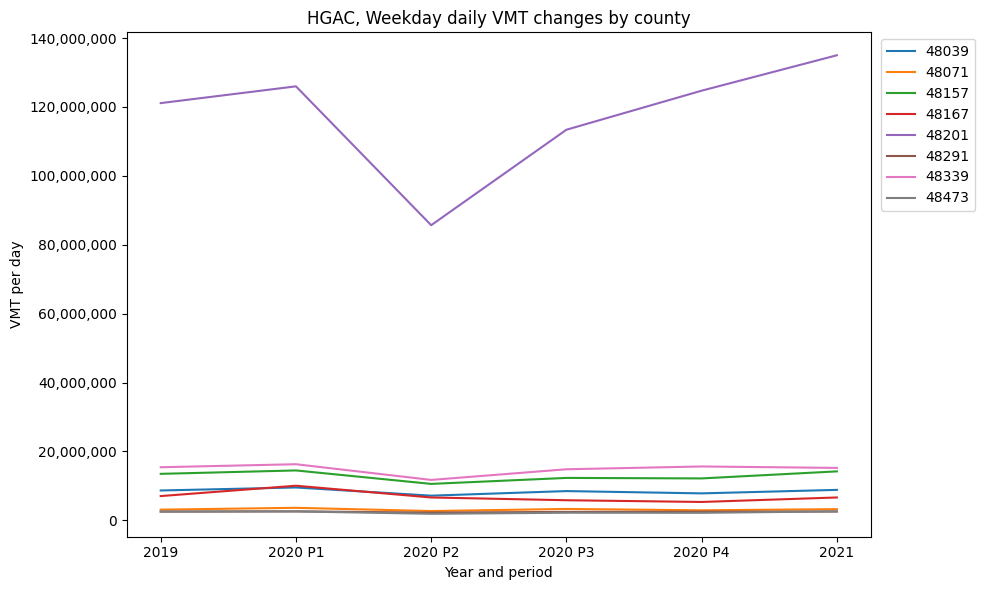

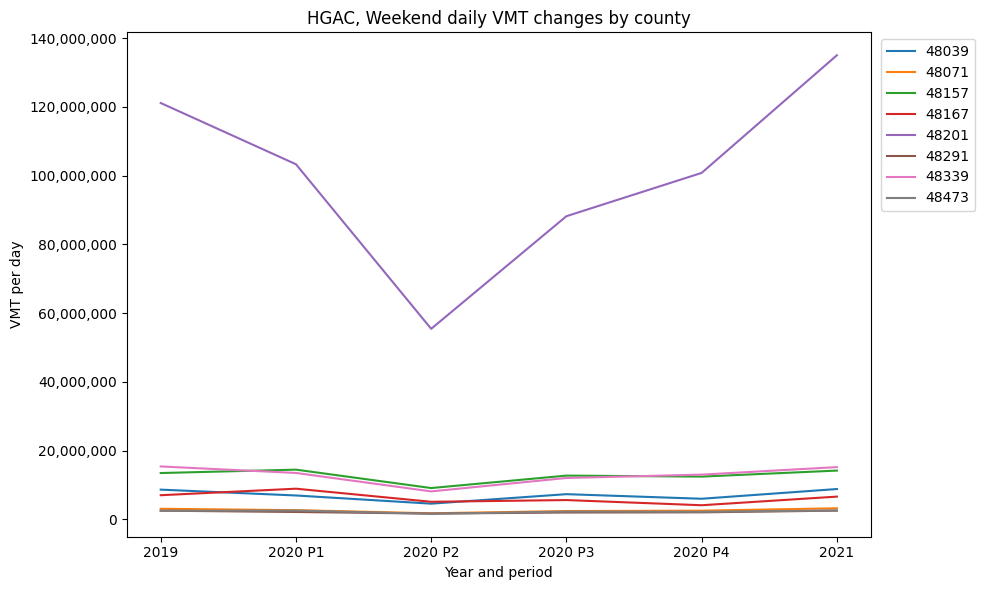

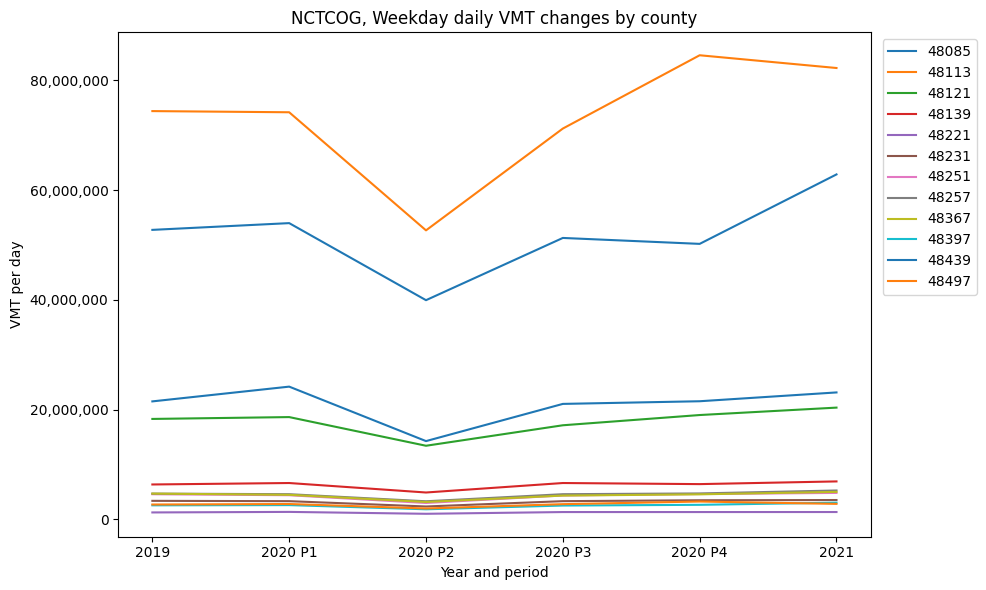

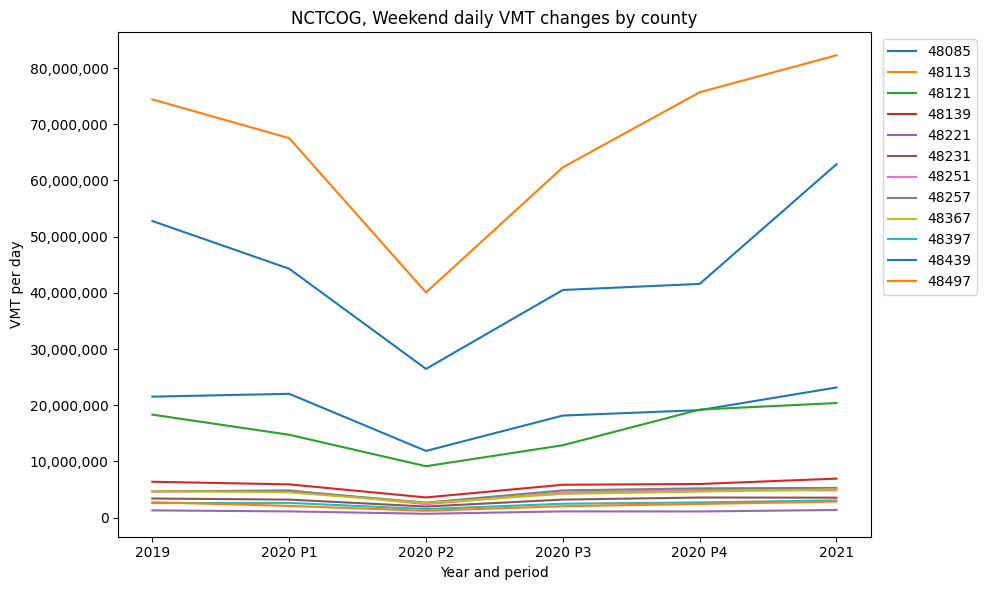

In [56]:
YearList = [*range(2020, 2021)]
AreaList = ['HGAC', 'NCTCOG']
DaytypeList = ['Weekday', 'Weekend']

# YearList = [*range(2020, 2021)]
# AreaList = ['HGAC']
# DaytypeList = ['Weekday']


# fig = plt.figure(figsize = (10, 6))
# ax = plt.axes()

x = ['2019', '2020 P1', '2020 P2', '2020 P3', '2020 P4', '2021']

for Area in AreaList:
    for DayType in DaytypeList:
        fig, ax = plt.subplots(figsize = (10, 6))
        CountyList = np.array(df_VMT_Pred.loc[Area, DayType, :].index)
        for County in CountyList:
            list_VMT = np.array(df_VMT_Pred.loc[Area, DayType, County])
            ax.plot(x, list_VMT, label = County)
            ax.set_title(Area + ', ' + DayType + " daily VMT changes by county")
            ax.set_xlabel('Year and period')
            ax.set_ylabel('VMT per day')
            ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        
        fig.tight_layout()
        plt.show()

# <font color='yellow'> 5. Distribute total VMT to link-level VMT </font>

1. Assign total VMT by county to each link in county

In [34]:
## Read all CSV files
OutputFolder = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Python\\Output"
VMT_Pred_Output = "VMT_Pred_Output.csv"

df_VMT_Pred = pd.read_csv(os.path.join(OutputFolder, VMT_Pred_Output))
df_VMT_Pred = df_VMT_Pred.set_index(['Area', 'DayType', 'County']) ## Final Product


## Same clipped GRID data that I used previosly
DataPath = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Task5_GISWork\\Clipped_Table_RemoveLGRG" 
AreaList = ['HGAC', 'NCTCOG']
DaytypeList = ['Weekday', 'Weekend']
PeriodList = ['2020_P1', '2020_P2', '2020_P3', '2020_P4']
df_link = pd.DataFrame()

for Area in AreaList:
    FileName = Area + '_2020_Int.csv' ## Use 2020 VMT link distribution, 2020 link distribution is used for 'with COVID' case
    FilePath = os.path.join(DataPath, FileName)
    print (FilePath)
    df = pd.read_csv(FilePath)
    df_link = df_link.append(df) ## Merge HGAC and NCTCOG link data, save as df_link


df_link = df_link[['ID_GIS', 'Area', 'FIPS', 'F_SYSTEM', 'SPD_MAX', 'ADT_CUR', 'AADT_TRUCK', 'AADT_SINGL', 'AADT_COMBI', 'NUM_LANES', 'Length_mi']] ## Select necessary columns
df_link = df_link.loc[df_link['FIPS'].isin([48257, 48139, 48221, 48251, 48231, 48497, 48121, 48085, 48397, 48367, 48113, 48439, 48291, 48473, 48201, 48339, 48071, 48157, 48167, 48039])] ## Leave links in NCTCOG and HGAC only
df_link = RecalculateVMT(df_link) ## Recalculate VMT since link length is changed due to clipping
df_group = df_link.groupby(['FIPS']).sum() ## Get sum of VMT by county(FIPS)
CountyList = np.sort(np.array(df_link['FIPS'].unique())) ## Get county list

for County in CountyList:
    VMT_Sum_ByCounty = df_group.loc[County]['VMT']
    df_link.loc[df_link['FIPS'] == County, 'VMT_Pct'] = df_link.loc[df_link['FIPS'] == County, 'VMT'] / VMT_Sum_ByCounty ## Save % of VMT by each county at 'VMT_Pct' column. i.e., Sum of VMT % in FIPS 48201 is 1

df_link = df_link.reset_index(drop=True) ## Reset index for iteration

StartTime = time.time() ## Initialize stopwatch

for idx, row in df_link.iterrows():
    County = df_link.loc[idx, 'FIPS']
    ##County = row['FIPS']
    for Daytype in DaytypeList:
        for Period in PeriodList:
            VMT_Pred = float(df_VMT_Pred.loc[:, Daytype, County][Period]) ## Get predicted VMT in each county, each period
            ColumnName = 'VMT_Pred_' + Period + '_' + Daytype
            df_link.at[idx, ColumnName] = df_link.loc[idx, 'VMT_Pct'] * VMT_Pred ## Use .at instead of .loc

            
    if int(idx) % 1000 == 0: ## Check running time
        EndTime = time.time()
        Duration = EndTime - StartTime
        print ("Index = %d, Running Time = %.2f Second" % (idx, Duration))
        StartTime = time.time()


OutputFolder = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Python\\Output"
VMT_Pred_byLink_Output = "VMT_Pred_byLink_Output.csv"

df_link.to_csv(os.path.join(OutputFolder, VMT_Pred_byLink_Output))
       


X:\HEA - Active Projects\441320 - TxDOT RTI - Transportation AQ Impacts\Tasks\Task 5. Emission Estimation\GIS Work\Task5_GISWork\Clipped_Table_RemoveLGRG\HGAC_2020_Int.csv


C:\Users\B-Kim\AppData\Local\Temp\ipykernel_34412\3944434437.py:20: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FilePath)
C:\Users\B-Kim\AppData\Local\Temp\ipykernel_34412\3944434437.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_link = df_link.append(df) ## Merge HGAC and NCTCOG link data, save as df_link


X:\HEA - Active Projects\441320 - TxDOT RTI - Transportation AQ Impacts\Tasks\Task 5. Emission Estimation\GIS Work\Task5_GISWork\Clipped_Table_RemoveLGRG\NCTCOG_2020_Int.csv


C:\Users\B-Kim\AppData\Local\Temp\ipykernel_34412\3944434437.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_link = df_link.append(df) ## Merge HGAC and NCTCOG link data, save as df_link
C:\Users\B-Kim\AppData\Local\Temp\ipykernel_34412\3944434437.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_group = df_link.groupby(['FIPS']).sum() ## Get sum of VMT by county(FIPS)


Index = 0, Running Time = 0.12 Second
Index = 1000, Running Time = 3.03 Second
Index = 2000, Running Time = 2.88 Second
Index = 3000, Running Time = 2.87 Second
Index = 4000, Running Time = 3.07 Second
Index = 5000, Running Time = 3.02 Second
Index = 6000, Running Time = 2.94 Second
Index = 7000, Running Time = 2.89 Second
Index = 8000, Running Time = 2.92 Second
Index = 9000, Running Time = 2.90 Second
Index = 10000, Running Time = 2.86 Second
Index = 11000, Running Time = 2.84 Second
Index = 12000, Running Time = 2.88 Second
Index = 13000, Running Time = 2.90 Second
Index = 14000, Running Time = 2.89 Second
Index = 15000, Running Time = 2.89 Second
Index = 16000, Running Time = 2.88 Second
Index = 17000, Running Time = 2.87 Second
Index = 18000, Running Time = 2.91 Second
Index = 19000, Running Time = 2.89 Second
Index = 20000, Running Time = 2.89 Second
Index = 21000, Running Time = 2.85 Second
Index = 22000, Running Time = 2.89 Second
Index = 23000, Running Time = 2.99 Second
Index

# <font color='yellow'> 6. Distribute link-level daily VMT to link-level hourly VMT </font>

1. Hourly VMT, see X:\HEA - Active Projects\441320 - TxDOT RTI - Transportation AQ Impacts\Tasks\Task 5. Emission Estimation\STARS_Data_Analysis\STARSVol_DataAnalysis_02282023_BK.pbix, Hourly Vol Tab

In [37]:
## Read all CSV files

## Read link-level VMT data
OutputPath = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Python\\Output"
VMT_Pred_byLink_Output = "VMT_Pred_byLink_Output.csv"
df_link = pd.read_csv(os.path.join(OutputPath, VMT_Pred_byLink_Output))

## Detectors in HGAC and NCTCOG are limited. Only one functional class 5 detector exists in each area. 
## Use all detectors' hourly distribution in this example. (select four MPOs, since we want to represent urban areas' transportation activity)
## Export two tables (one for weekday, one for weekend)
## Select year 2020 for COVID transportation activity


## Load weekday and weekend hourly distribution by road functional class
df_hour = pd.DataFrame()
DataPath = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\STARS_Data_Analysis"
# VMT_HourlyDist_Weekday = "Ratios_byHour_byFuncClass_Weekday_03202023.csv"
# VMT_HourlyDist_Weekend = "Ratios_byHour_byFuncClass_Weekend_03202023.csv"
VMT_HourlyDist_Weekday = "Ratios_byHour_Weekday_03272023.csv" ## Decide to use single distribution for weekday/weekend
VMT_HourlyDist_Weekend = "Ratios_byHour_Weekend_03272023.csv"
df_hour_Weekday = pd.read_csv(os.path.join(DataPath, VMT_HourlyDist_Weekday))
df_hour_Weekend = pd.read_csv(os.path.join(DataPath, VMT_HourlyDist_Weekend))
df_hour_Weekday['Daytype'] = 'Weekday'
df_hour_Weekend['Daytype'] = 'Weekend'

## Merge hourly distribution dataframe into one, df_hour
df_hour = pd.concat([df_hour_Weekday, df_hour_Weekend])
df_hour = df_hour.set_index(['Hour', 'Daytype'])



df_link_hour = df_link
pred_VMT_list = ['VMT_Pred_2020_P1_Weekday','VMT_Pred_2020_P2_Weekday', 'VMT_Pred_2020_P3_Weekday','VMT_Pred_2020_P4_Weekday', 'VMT_Pred_2020_P1_Weekend','VMT_Pred_2020_P2_Weekend', 'VMT_Pred_2020_P3_Weekend','VMT_Pred_2020_P4_Weekend']

hour_list = [] ## Generate hour list
for i in range(1,25):
    if i <= 9:       val = 'H0' + str(i)
    else:            val = 'H'+str(i)
    hour_list.append(val)
    
for pred_VMT in pred_VMT_list: ## Initialize columns for hourly VMT (generate columns and assign 0)
    for hour in hour_list:
        ColName = pred_VMT + "_" + hour
        df_link_hour[ColName] = 0

StartTime = time.time() ## Initialize stopwatch

for idx, row in df_link_hour.iterrows():
    Func_class = df_link_hour.loc[idx, 'F_SYSTEM']
    if Func_class >= 5: Func_class = 5 ## If functional class is higher than 5, assign 5 (use Func class 5 hourly distribution)

    for pred_VMT in pred_VMT_list:
        Daytype = pred_VMT[-7:] ## Get daytype
        VMT_Daily = df_link_hour.at[idx, pred_VMT]
        
        for hour in hour_list:
            ##hour_dist = df_hour.at[(hour, Func_class, Daytype), 'HourlyVol'] ## get each hour's distribution by functional class and daytype -- decide to use single distribution for each daytype
            hour_dist = df_hour.at[(hour, Daytype), 'HourlyVol'] ## get each hour's distribution by daytype
            ColumnName = pred_VMT + "_" + hour

            df_link_hour.at[idx, ColumnName] = VMT_Daily * hour_dist ## Daily VMT * hourly distribution

    if int(idx) % 1000 == 0: ## Check running time
        EndTime = time.time()
        Duration = EndTime - StartTime
        print ("Index = %d, Running Time = %.2f Second" % (idx, Duration))
        StartTime = time.time()



VMT_Pred_byLink_byHour_Output = "VMT_Pred_byLink_byHour_Output.csv"
df_link_hour.to_csv(os.path.join(OutputPath, VMT_Pred_byLink_byHour_Output), index=False)




C:\Users\B-Kim\AppData\Local\Temp\ipykernel_34412\3075885062.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_link_hour[ColName] = 0
C:\Users\B-Kim\AppData\Local\Temp\ipykernel_34412\3075885062.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_link_hour[ColName] = 0
C:\Users\B-Kim\AppData\Local\Temp\ipykernel_34412\3075885062.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

Index = 0, Running Time = 12.49 Second
Index = 1000, Running Time = 11.87 Second
Index = 2000, Running Time = 11.82 Second
Index = 3000, Running Time = 11.90 Second
Index = 4000, Running Time = 12.13 Second
Index = 5000, Running Time = 12.18 Second
Index = 6000, Running Time = 13.20 Second
Index = 7000, Running Time = 13.04 Second
Index = 8000, Running Time = 11.95 Second
Index = 9000, Running Time = 12.59 Second
Index = 10000, Running Time = 11.87 Second
Index = 11000, Running Time = 11.91 Second
Index = 12000, Running Time = 11.90 Second
Index = 13000, Running Time = 11.99 Second
Index = 14000, Running Time = 11.92 Second
Index = 15000, Running Time = 11.86 Second
Index = 16000, Running Time = 11.86 Second
Index = 17000, Running Time = 11.90 Second
Index = 18000, Running Time = 11.93 Second
Index = 19000, Running Time = 11.74 Second
Index = 20000, Running Time = 11.71 Second
Index = 21000, Running Time = 12.00 Second
Index = 22000, Running Time = 11.76 Second
Index = 23000, Running T

# <font color='yellow'> 7. Estimate speed using BPR </font>

1. Calibrate BPR
1. Estimate speed using calibrated BPR

## <font color='pink'> 7.1. BPR Function definition </font>

BPR Function model parameters

The BPR function is formulated as a polynomial function with respect to the ratio of trafﬁc volume to capacity. The alpha (α) and beta (β) are parameters of the BPR function and, thus, represent the performance of a network (3). The α is the scale parameter; the β is the shape parameter, and its value varies between cities. The parameter of BPR function α is the ratio of travel time per unit distance at practical capacity to the free flow, and parameter β determines how fast the curve increases from the free-flow travel time (4). Generally, α  = 0.15 and β  = 4 are used. A higher value of β indicates that the onset of congestion becomes more and more sudden (5).

'Modified Bureau of Public Roads Link Function, TRR 2022'
https://journals-sagepub-com.srv-proxy1.library.tamu.edu/doi/full/10.1177/03611981221138511#:~:text=The%20Bureau%20of%20Public%20Roads,field%20variables%2C%20and%20consistent%20performance.

Ta = Tf(1+a * (v/c)^b)


In [13]:
## Check link length by functional class and speed limit

OutputPath = "X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\GIS Work\\Python\\Output"
VMT_Pred_byLink_Output = "VMT_Pred_byLink_Output.csv"
df_link = pd.read_csv(os.path.join(OutputPath, VMT_Pred_byLink_Output))
print (df_link.columns)

df_link_filter = df_link[['F_SYSTEM', 'SPD_MAX', 'Length_mi']]


df_link_filter_summary = df_link_filter.groupby(['F_SYSTEM', 'SPD_MAX']).sum()
df_link_filter_summary_Output = "Length by FClass and Speed Limit.csv"
df_link_filter_summary.to_csv(os.path.join(OutputPath, df_link_filter_summary_Output))

## In functional class 1-7, some segments' speed limit is 0
## Checked in GIS, all junction/interchange has no speed limit
## Assign single value? (i.e., 30 mph?)


Index(['Unnamed: 0', 'ID_GIS', 'Area', 'FIPS', 'F_SYSTEM', 'SPD_MAX',
       'ADT_CUR', 'AADT_TRUCK', 'AADT_SINGL', 'AADT_COMBI', 'NUM_LANES',
       'Length_mi', 'VMT', 'VMT_Pct', 'VMT_Pred_2020_P1_Weekday',
       'VMT_Pred_2020_P2_Weekday', 'VMT_Pred_2020_P3_Weekday',
       'VMT_Pred_2020_P4_Weekday', 'VMT_Pred_2020_P1_Weekend',
       'VMT_Pred_2020_P2_Weekend', 'VMT_Pred_2020_P3_Weekend',
       'VMT_Pred_2020_P4_Weekend'],
      dtype='object')


In [12]:
def BPR (Volume, FFS, Capacity, a, b): ## Current volume, Free flow speed, Capacity, model parameter a and b, returns speed
    ## Assume 1 mi of travel length
    ## TT = inverse of speed (hr/mi) --> how many hours for 1 mi driving
    FFTime = 1/FFS
    TT = FFTime * (1 + a * (pow(Volume/Capacity, b)))
    Speed = 1/TT
    return Speed


Test = BPR (1200, 70, 2200, 0.15, 4)
print (Test)

69.08273454035618


In [18]:
## Get speed-volume pair
FolderPath = 'X:\\HEA - Active Projects\\441320 - TxDOT RTI - Transportation AQ Impacts\\Tasks\\Task 5. Emission Estimation\\STARS_Data_Analysis\\Output'
Spd_Vol_File = 'Speed_Volume_2020.csv'
df_spd_vol = pd.read_csv(os.path.join(FolderPath, Spd_Vol_File))

df_spd_vol = df_spd_vol.rename(columns={'STARS2_Perm_Speed_2015-21_Processed_Date Time': 'DateTime', 'STARS2_Perm_Speed_2015-21_Processed_FUNCTIONAL_CLASS': 'Functional Class', 'STARS2_Perm_Speed_2015-21_Processed_LOCAL_ID': 'ID'})
df_spd_vol = df_spd_vol[['DateTime', 'Weighted Avg Speed', 'Vol per Lane', 'SpeedLimit', 'Functional Class']]

df_spd_vol


,DateTime,Weighted Avg Speed,Vol per Lane,SpeedLimit,Functional Class
0,1/1/2020 0:00,67.5,355.2,60,1
1,1/1/2020 0:00,70.3,250.3,65,1
2,1/1/2020 0:00,67.2,317.7,65,1
3,1/1/2020 0:00,62.4,307.7,65,1
4,1/1/2020 0:00,74.0,477.3,70,1
...,...,...,...,...,...
468625,12/31/2020 12:00,63.4,288.5,65,2
468626,12/31/2020 12:00,67.8,282.5,70,3
468627,12/31/2020 12:00,71.6,317.0,75,3
468628,12/31/2020 12:00,70.9,299.0,70,3


In [75]:
#### Pandas testing


df_link_hour = df_link

# print (df_link_hour.head(5))


Test1 = df_link_hour.at[0, 'FIPS']
print (Test1)

Test2 = df_link_hour.at[(0, 'FIPS')] 
print (Test2)

Test3 = df_link_hour.loc[0, 'FIPS']
print (Test3)

Test4 = df_link_hour.loc[0]['FIPS']
print (Test4)

df_hour_test = df_hour

## If multiple index?


print (df_hour_test.head(5))


Test5 = df_hour_test.loc['H01', 1, 'Weekday']['HourlyVol']
print (Test5)

Test6 = df_hour_test.at[('H01', 1, 'Weekday'), 'HourlyVol']
print (Test6)


48201
48201
48201
48201.0
                               HourlyVol
Hour FUNCTIONAL_CLASS Daytype           
H01  1                Weekday   0.010609
     2                Weekday   0.006107
     3                Weekday   0.005846
     4                Weekday   0.006163
     5                Weekday   0.006713
0.010608809038419
0.010608809038419


In [39]:
data = {
  "calories": [420, 380, 390],
  "duration": [50, 40, 45]
}

#load data into a DataFrame object:
df = pd.DataFrame(data)

print(df) 

##df = df[df['calories'] != 380]

df = df[~df['calories'].isin([380, 420])]

print (df)

df['test'] = "test"

print (df)

df = df.rename(columns = {'calories': 'cal'})

print (df)

df_VMT_Pred

VMT_Pred = float(df_VMT_Pred.loc[:, Daytype, County][Period]) ## Get predicted VMT in each county, each period

   calories  duration
0       420        50
1       380        40
2       390        45
   calories  duration
2       390        45
   calories  duration  test
2       390        45  test
   cal  duration  test
2  390        45  test


2019       2020_P1       2020_P2       2020_P3  \
Area   DayType County                                                           
HGAC   Weekday 48039   8.649528e+06  9.522478e+06  7.141859e+06  8.475006e+06   
       Weekend 48039   8.649528e+06  6.951409e+06  4.570790e+06  7.332308e+06   
       Weekday 48071   3.085034e+06  3.616341e+06  2.676093e+06  3.290871e+06   
       Weekend 48071   3.085034e+06  2.676093e+06  1.772007e+06  2.422949e+06   
       Weekday 48157   1.347925e+07  1.446725e+07  1.056109e+07  1.229716e+07   
       Weekend 48157   1.347925e+07  1.446725e+07  9.114366e+06  1.273118e+07   
       Weekday 48167   7.026414e+06  1.002990e+07  6.619735e+06  5.817343e+06   
       Weekend 48167   7.026414e+06  8.926613e+06  5.115250e+06  5.616745e+06   
       Weekday 48201   1.211273e+08  1.259948e+08  8.567649e+07  1.133954e+08   
       Weekend 48201   1.211273e+08  1.033158e+08  5.543773e+07  8.819639e+07   
       Weekday 48291   2.528580e+06  2.587743e+06  2.225459e+06  2.432479e+06   
       Weekend 48291   2.528580e+06  2.147827e+06  1.682033e+06  1.992562e+06   
       Weekday 48339   1.539876e+07  1.627326e+07  1.171675e+07  1.480867e+07   
       Weekend 48339   1.539876e+07  1.350680e+07  8.136629e+06  1.204221e+07   
       Weekday 48473   2.504337e+06  2.575290e+06  1.879961e+06  2.188996e+06   
       Weekend 48473   2.504337e+06  2.575290e+06  1.622432e+06  2.266255e+06   
NCTCOG Weekday 48085   2.152120e+07  2.421084e+07  1.428440e+07  2.106343e+07   
       Weekend 48085   2.152120e+07  2.203187e+07  1.186331e+07  1.815813e+07   
       Weekday 48113   7.442347e+07  7.421014e+07  5.268920e+07  7.124174e+07   
       Weekend 48113   7.442347e+07  6.753123e+07  4.007348e+07  6.233652e+07   
       Weekday 48121   1.832403e+07  1.866158e+07  1.343634e+07  1.716866e+07   
       Weekend 48121   1.832403e+07  1.474265e+07  9.144176e+06  1.287649e+07   
       Weekday 48139   6.380725e+06  6.644713e+06  4.917088e+06  6.644713e+06   
       Weekend 48139   6.380725e+06  5.913795e+06  3.588145e+06  5.847348e+06   
       Weekday 48221   1.284505e+06  1.382034e+06  1.036526e+06  1.354394e+06   
       Weekend 48221   1.284505e+06  1.105627e+06  6.771968e+05  1.105627e+06   
       Weekday 48231   3.397074e+06  3.338043e+06  2.370011e+06  3.338043e+06   
       Weekend 48231   3.397074e+06  3.204522e+06  1.969446e+06  3.204522e+06   
       Weekday 48251   4.603732e+06  4.420952e+06  3.006247e+06  4.376742e+06   
       Weekend 48251   4.603732e+06  4.863047e+06  2.387314e+06  4.465162e+06   
       Weekday 48257   4.714750e+06  4.608650e+06  3.318228e+06  4.608650e+06   
       Weekend 48257   4.714750e+06  4.746909e+06  2.673017e+06  4.839082e+06   
       Weekday 48367   4.718051e+06  4.492855e+06  3.189927e+06  4.358070e+06   
       Weekend 48367   4.718051e+06  4.492855e+06  2.605856e+06  4.223284e+06   
       Weekday 48397   2.579925e+06  2.619475e+06  1.859827e+06  2.540890e+06   
       Weekend 48397   2.579925e+06  2.619475e+06  1.519295e+06  2.462306e+06   
       Weekday 48439   5.277833e+07  5.400798e+07  3.996591e+07  5.130758e+07   
       Weekend 48439   5.277833e+07  4.428655e+07  2.646391e+07  4.050599e+07   
       Weekday 48497   2.726521e+06  2.819952e+06  2.002166e+06  2.791753e+06   
       Weekend 48497   2.726521e+06  2.086765e+06  1.212579e+06  2.030366e+06   

                            2020_P4          2021  
Area   DayType County                              
HGAC   Weekday 48039   7.808432e+06  8.823979e+06  
       Weekend 48039   5.999161e+06  8.823979e+06  
       Weekday 48071   2.893073e+06  3.231857e+06  
       Weekend 48071   2.531439e+06  3.231857e+06  
       Weekday 48157   1.215249e+07  1.419509e+07  
       Weekend 48157   1.244183e+07  1.419509e+07  
       Weekday 48167   5.315848e+06  6.619950e+06  
       Weekend 48167   4.112260e+06  6.619950e+06  
       Weekday 48201   1.247349e+08  1.350193e+08  
       Weekend 48201   1.007959e+08  1.350193e+08  
    